In [4]:
import torch
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from easydict import EasyDict

import json
from consts import WEIGHT_DIR
import systems.a2mim_utils as a2u
import systems.a2mim as a2

from importlib import reload
from models.resnet import resnet50
from models import ARCHITECTURES
from dsets.imagenet import ImageNet, TRAIN_TRANSFORM
from easydict import EasyDict
from consts import SEED, CLASS_SUBSET_100

## christos stuff

In [6]:
# CHRISTOS FINAL MIXEDMASK CODE
from utils import load_config
cfg = load_config('mixed_mask')
model = resnet50(num_classes=100)
sys = a2.A2MIMSystem(
    cfg=cfg,
    model=model,
    trn_dset=ImageNet('train', subset_classes=CLASS_SUBSET_100, transform=TRAIN_TRANSFORM),
    val_dset=ImageNet('val', subset_classes=CLASS_SUBSET_100),
    device='cuda',
    seed=None
)
a2.load_weights(sys.full_model, weight_name='mixed_mask_l2l4_full-best', backbone_only=False)

paramwise_options -- backbone.bn1.weight: weight_decay=0.0
paramwise_options -- backbone.bn1.bias: weight_decay=0.0
paramwise_options -- backbone.bn1.bias: weight_decay=0.0
paramwise_options -- backbone.layer1.0.bn1.weight: weight_decay=0.0
paramwise_options -- backbone.layer1.0.bn1.bias: weight_decay=0.0
paramwise_options -- backbone.layer1.0.bn1.bias: weight_decay=0.0
paramwise_options -- backbone.layer1.0.bn2.weight: weight_decay=0.0
paramwise_options -- backbone.layer1.0.bn2.bias: weight_decay=0.0
paramwise_options -- backbone.layer1.0.bn2.bias: weight_decay=0.0
paramwise_options -- backbone.layer1.0.bn3.weight: weight_decay=0.0
paramwise_options -- backbone.layer1.0.bn3.bias: weight_decay=0.0
paramwise_options -- backbone.layer1.0.bn3.bias: weight_decay=0.0
paramwise_options -- backbone.layer1.0.downsample.1.bias: weight_decay=0.0
paramwise_options -- backbone.layer1.1.bn1.weight: weight_decay=0.0
paramwise_options -- backbone.layer1.1.bn1.bias: weight_decay=0.0
paramwise_options 

MASK LAYER = 4


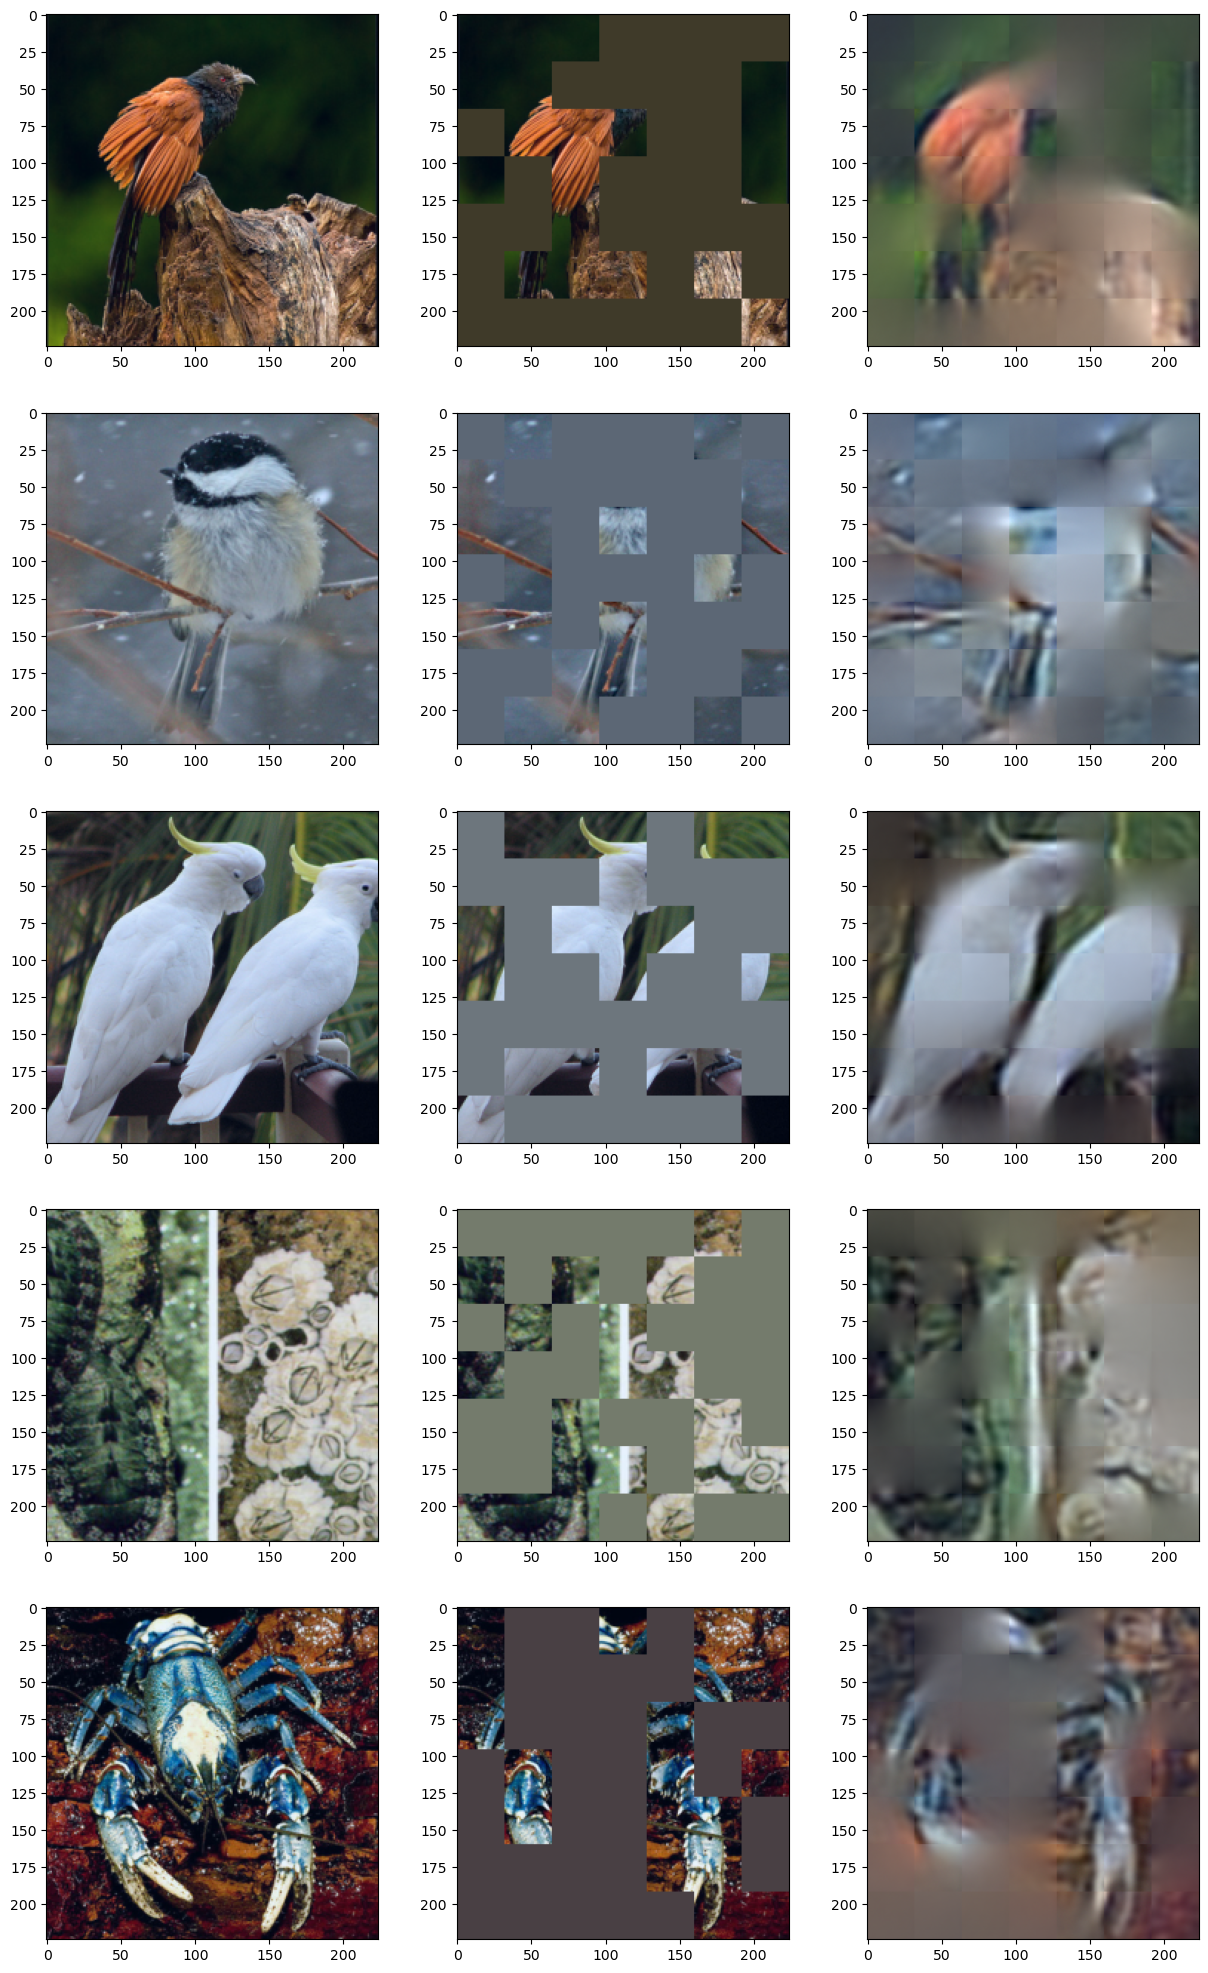

In [8]:
# val_sampler = torch.utils.data.sampler.BatchSampler(
#     torch.utils.data.sampler.SequentialSampler(sys.val_dset),
#     batch_size=sys.cfg.dl_kwargs.batch_size,
#     drop_last=False
# )
# val_dl = DataLoader(sys.val_dset, sampler=val_sampler, collate_fn=lambda a: a[0])

# for batch in val_dl:
#     print(f'MASK LAYER = {batch.layer}')
#     with torch.no_grad():
#         img_raw = batch.x.to(sys.device)
#         img_mask = batch.x_mask.to(sys.device)
#         mask = batch.mask.to(sys.device)
#         img_rec = sys.full_model(img_mask, mask=mask, layer=batch.layer)
#     break

batch = sys.val_dset.__getitem__(range(128))
print(f'MASK LAYER = {batch.layer}')
with torch.no_grad():
    img_raw = batch.x.to(sys.device)
    img_mask = batch.x_mask.to(sys.device)
    mask = batch.mask.to(sys.device)
    img_rec = sys.full_model(img_mask, mask=mask, layer=batch.layer)

def restore(img_tensor):
    img = img_tensor.cpu().detach().numpy()
    if img.shape[0] == 3:
        img = img.transpose(1, 2, 0)
    # Normalize pixel values to [0, 1]
    # this is technically wrong -- you should use the std and mean values from DEFAULT_TRANSFORM
    # in imagenet.py but i cant be bothered rn
    img = (img - img.min()) / (img.max() - img.min())
    return img
    
fig, ax = plt.subplots(nrows=5, ncols=3, figsize=(15,25))
for i in range(5):
    ax[i, 0].imshow(restore(img_raw[i]))
    ax[i, 1].imshow(restore(img_mask[i]))
    ax[i, 2].imshow(restore(img_rec[i]))
plt.show()

## old

In [ ]:
trn_dset = ImageNet('train', subset_classes=CLASS_SUBSET_100, transform=TRAIN_TRANSFORM)
val_dset = ImageNet('val', subset_classes=CLASS_SUBSET_100)

In [ ]:
cfg_name = 'gen_a2mim_res50'

with open(f'configs/{cfg_name}.json', 'r') as f:
    config_dict = json.load(f)

cfg = EasyDict(config_dict)
cfg.mask_layer = 2
cfg.mask_gen_cfg.mask_patch_size = 4
cfg.mask_gen_cfg.mask_ratio = 0.8
weight_name = f'layer{cfg.mask_layer}_patch{cfg.mask_gen_cfg.mask_patch_size}_ratio{int(100*cfg.mask_gen_cfg.mask_ratio)}_full-best'

model = ARCHITECTURES[cfg.arch](num_classes=100)
device = 'cpu'

In [ ]:
backbone = a2u.inject_mask(model, cfg.mask_cfg, layer=cfg.mask_layer)
full_model = a2u.A2MIMModel(backbone)
a2.load_weights(full_model, weight_name=weight_name, backbone_only=False)
full_model.to(device)
trn_dset = a2u.MaskedDataset(trn_dset, mask_gen_cfg=cfg.mask_gen_cfg, mask_layer=cfg.mask_layer)
val_dset = a2u.MaskedDataset(val_dset, mask_gen_cfg=cfg.mask_gen_cfg, mask_layer=cfg.mask_layer)

<All keys matched successfully>


In [ ]:
trn_dl = DataLoader(trn_dset, **cfg.dl_kwargs, shuffle=True)
val_dl = DataLoader(val_dset, **cfg.dl_kwargs)

batch_out = EasyDict()
img_raw = None
img_rec = None

for batch in val_dl:
    with torch.no_grad():
        img_raw = batch.x.to(device)
        img_mask = batch.x_mask.to(device)
        mask = batch.mask.to(device)
        img_rec = full_model(img_mask, mask=mask)
    break

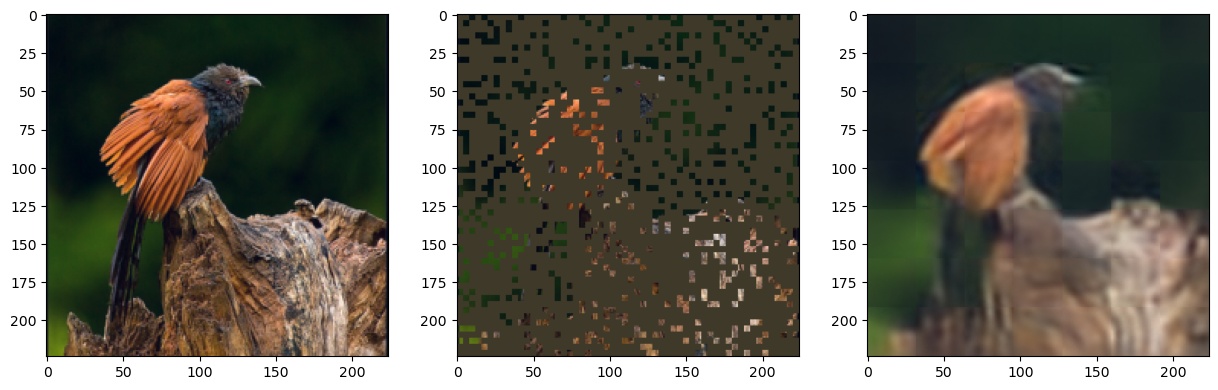

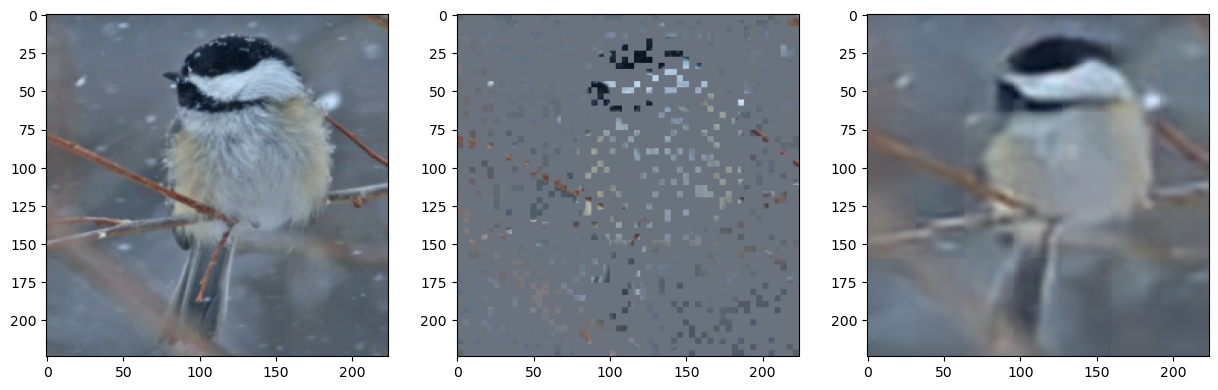

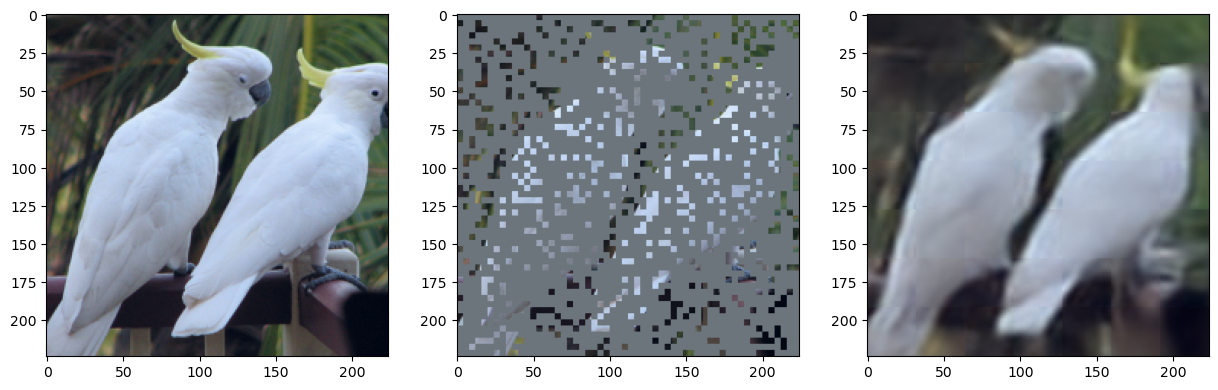

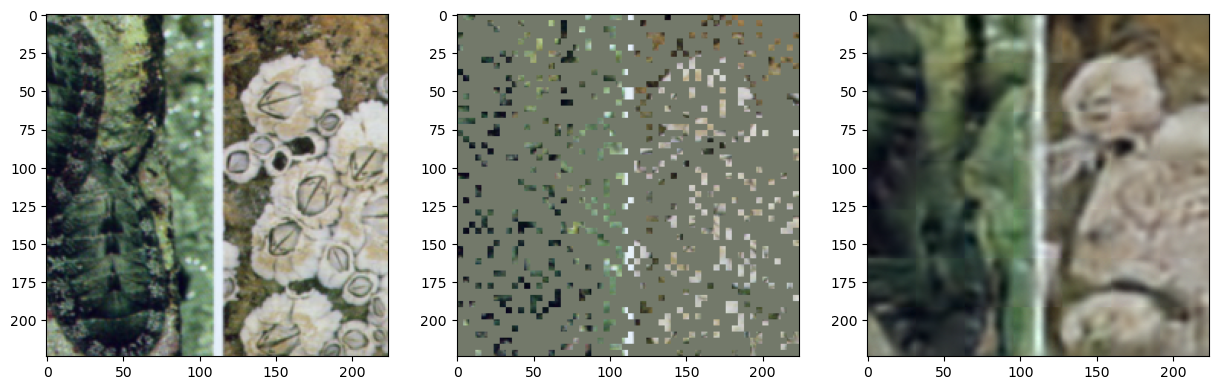

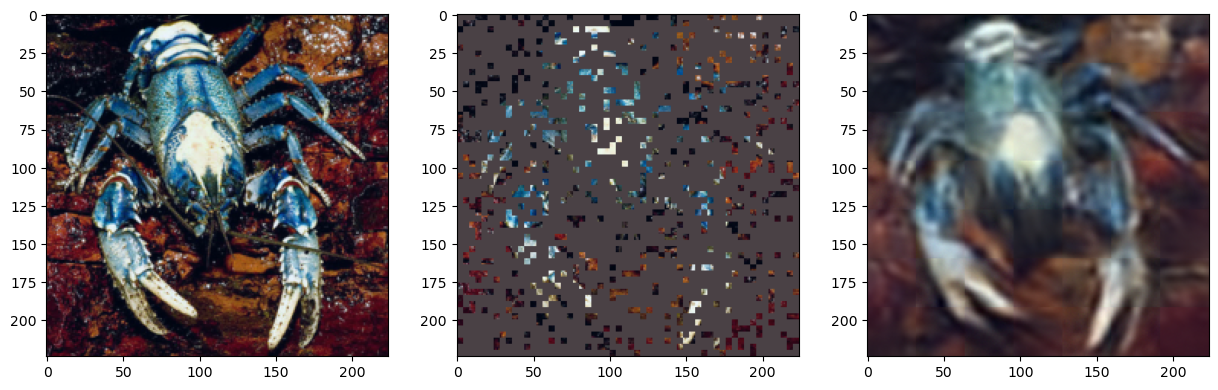

In [ ]:
def restore(img_tensor):
    img = img_tensor.cpu().detach().numpy()
    if img.shape[0] == 3:
        img = img.transpose(1, 2, 0)
    # Normalize pixel values to [0, 1]
    # this is technically wrong -- you should use the std and mean values from DEFAULT_TRANSFORM
    # in imagenet.py but i cant be bothered rn
    img = (img - img.min()) / (img.max() - img.min())
    return img
    
for i in range(5):
    fig, ax = plt.subplots(ncols=3, figsize=(15,5))
    ax[0].imshow(restore(img_raw[i]))
    ax[1].imshow(restore(img_mask[i]))
    ax[2].imshow(restore(img_rec[i]))
    plt.show()